# Implementation of Proximal Policy Optimization on CartPole-v0
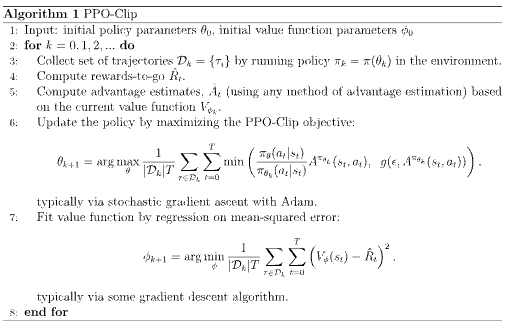
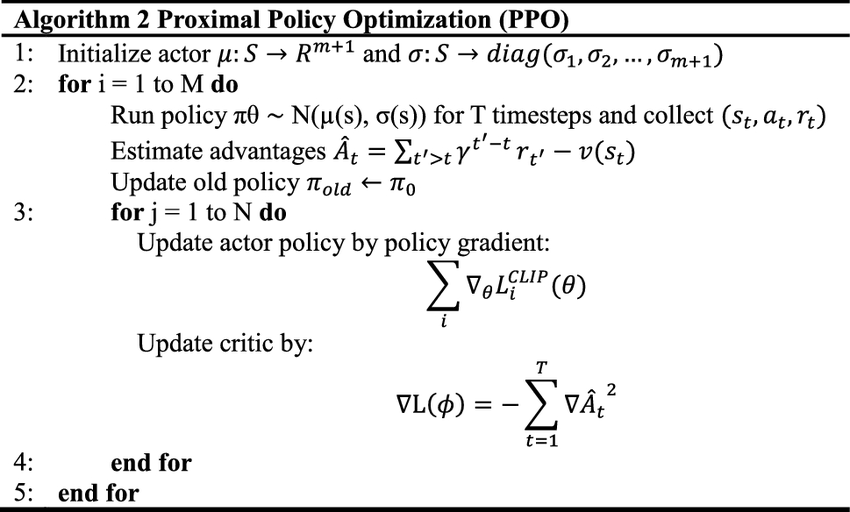

In [10]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.distributions as distributions

## Policy

In [11]:
# Initilization
maxSteps = 500
trainEnv = gym.make("CartPole-v1",max_episode_steps=500) # For some reason may maxEpisodeSteps is not stopping when it reaches episode steps
testEnv = gym.make("CartPole-v1",max_episode_steps=500)

# Set the Seed for reproduciability
seed = 1234
trainEnv.reset(seed=seed)
testEnv.reset(seed=seed+1)
np.random.seed(seed)
torch.manual_seed(seed)

In [12]:
# Making the Policy
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.5):
        super().__init__()

        self.fc_1 = nn.Linear(input_dim, hidden_dim) # Input Dim = Observation Space Dimension
        self.fc_2 = nn.Linear(hidden_dim, output_dim) # Output Layer = Action Space Dimension
        self.dropout = nn.Dropout(dropout) # TODO Prevent Overfitting? Not sure why need to investigate this more
    
    def forward(self, x):
        x = self.fc_1(x)
        x = self.dropout(x)
        x = F.relu(x)
        x = self.fc_2(x)
        return x

class ActorCritic(nn.Module):
    def __init__(self, actor, critic):
        super().__init__()

        self.actor = actor
        self.critic = critic
    
    def forward(self, state):
        actionPred = self.actor(state)
        valuePred = self.critic(state)

        return actionPred, valuePred

inputDimension = trainEnv.observation_space.shape[0]
hiddenDimension = 128 # TODO Figure out how to optimize this value
outputDimension = trainEnv.action_space.n 

actor = MLP(inputDimension, hiddenDimension, outputDimension)
critic = MLP(inputDimension, hiddenDimension, 1)

policy = ActorCritic(actor,critic)

In [13]:
# Initial Policy Theta Values
def initWeights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight) # TODO Why people use xavier weights
        m.bias.data.fill_(0)

policy.apply(initWeights)

ActorCritic(
  (actor): MLP(
    (fc_1): Linear(in_features=4, out_features=128, bias=True)
    (fc_2): Linear(in_features=128, out_features=2, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (critic): MLP(
    (fc_1): Linear(in_features=4, out_features=128, bias=True)
    (fc_2): Linear(in_features=128, out_features=1, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [14]:
learningRate = 0.01
optimizer = optim.Adam(policy.parameters(), lr=learningRate)

## Advantage Estimates
The method for calculating advantage estimates in this is:

$A_t=R_{t}-V(s_{t})$ where $R_{t}=$ Return at time t

We normalize the advantage function and subtract from the mean for PPO agents similar to subtracting a baseline from the policy gradient loss. [Source](https://github.com/openai/baselines/issues/544)

Normalize advantages across single mini batches is typically the preferred method, however in this project we normalize advantage across single episodes. [Source](https://www.reddit.com/r/reinforcementlearning/comments/rxan53/normalizing_advantage_estimates_in_ppo/)

## PPO-Clip Objective

In [15]:
# Helper Functions
def calculateReturns(rewards, discountFactor, normalize=True):
    returns = []
    R = 0

    for r in reversed(rewards):
        R = r+ R * discountFactor
        returns.insert(0,R)
    
    returns = torch.tensor(returns)

    if normalize:
        returns = (returns - returns.mean()) / returns.std()
    
    return returns

def calculateAdvantages(returns, values, normalize=True):
    advantages = returns - values

    if normalize:
        advantages = (advantages - advantages.mean()) / advantages.std()
    
    return advantages

def updatePolicy(policy, states, actions, probActions, advantages, returns, optimizer, ppoSteps, ppoClip):
    totalPolicyLoss = 0
    totalValueLoss = 0

    advantages = advantages.detach()
    probActions = probActions.detach()
    actions = actions.detach()

    for _ in range(ppoSteps):
        # New Probability of actions
        actionPred, valuePred = policy(states)
        valuePred = valuePred.squeeze(-1)
        actionProb = F.softmax(actionPred)
        dist = distributions.Categorical(actionProb)

        # Log new probability using old actions
        newActionProb = dist.log_prob(actions)
        policyRatio = (newActionProb - probActions).exp()

        policyLoss1 = policyRatio * advantages
        policyLoss2 = torch.clamp(policyRatio, min=1.0-ppoClip, max=1.0+ppoClip)*advantages

        policyLoss = -torch.min(policyLoss1, policyLoss2).sum()

        valueLoss = F.smooth_l1_loss(returns, valuePred).sum()

        optimizer.zero_grad()

        policyLoss.backward()
        valueLoss.backward()

        optimizer.step()

        totalPolicyLoss += policyLoss.item()
        totalValueLoss += valueLoss.item()

    return totalPolicyLoss / ppoSteps, totalValueLoss / ppoSteps

In [16]:
# Training Code
def train(env, policy, optimizer, discountFactor, ppoStep, ppoClip):
    policy.train()
    
    states = []
    actions = []
    logProbActions = []
    values = []
    rewards = []
    done = False
    episodeReward = 0

    state, _ = env.reset()

    while not done:
        state = torch.FloatTensor(state).unsqueeze(0)
        states.append(state)
        actionPred, valuePred = policy(state)
        actionProb = F.softmax(actionPred, dim=-1)
        dist = distributions.Categorical(actionProb)
        action = dist.sample()
        logProbAction = dist.log_prob(action)

        state, reward, done, _, _= env.step(action.item())

        actions.append(action)
        logProbActions.append(logProbAction)
        values.append(valuePred)
        rewards.append(reward)

        episodeReward += reward

        if len(states) > maxSteps:
            break

    states = torch.cat(states)
    actions = torch.cat(actions)
    logProbActions = torch.cat(logProbActions)
    values = torch.cat(values).squeeze(-1)

    returns = calculateReturns(rewards, discountFactor)
    advantages = calculateAdvantages(returns, values)

    policyLoss, valueLoss = updatePolicy(policy, states, actions, logProbActions, advantages, returns, optimizer, ppoStep, ppoClip)

    return policyLoss, valueLoss, episodeReward


In [17]:
def evaluate(env, policy):
    policy.eval()
    
    stepsRan = 0
    done = False
    episode_reward = 0

    state, _ = env.reset()

    while not done:
        state = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            action_pred, _ = policy(state)
            action_prob = F.softmax(action_pred, dim = -1)
        action = torch.argmax(action_prob, dim = -1)  
        state, reward, done, _, _ = env.step(action.item())
        episode_reward += reward
        
        stepsRan += 1
        if stepsRan > maxSteps:
            break
    return episode_reward

In [18]:
# Running the training

maxEpisodes = 500
discountFactor = 0.99
nTrials = 25
rewardThreshold = 475
printEvery = 10
ppoStep = 5
ppoClip = 0.2

trainRewards = []
testRewards = []

for episode in range(1, maxEpisodes+1):
    policyLoss, valueLoss, trainReward = train(trainEnv, policy, optimizer, discountFactor, ppoStep, ppoClip)

    testReward = evaluate(testEnv, policy)

    trainRewards.append(trainReward)
    testRewards.append(testReward)

    meanTrainRewards = np.mean(trainRewards[-nTrials:])
    meanTestRewards = np.mean(testRewards[-nTrials:])

    if episode % printEvery == 0:
        print(f'| Episode: {episode:3} | Mean Train Rewards: {meanTrainRewards:5.1f} | Mean Test Rewards: {meanTestRewards:5.1f} |')
    
    if meanTestRewards >= rewardThreshold:
        print(f'Reached reward threshold in {episode} episodes')
        break
    

/var/folders/ly/khp2t7sn2pj1zr1pb5_22hp00000gn/T/ipykernel_98422/2512094333.py:37: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  actionProb = F.softmax(actionPred)


| Episode:  10 | Mean Train Rewards:  22.7 | Mean Test Rewards:  25.7 |
| Episode:  20 | Mean Train Rewards:  37.9 | Mean Test Rewards:  62.0 |
| Episode:  30 | Mean Train Rewards:  41.3 | Mean Test Rewards:  84.6 |
| Episode:  40 | Mean Train Rewards:  60.3 | Mean Test Rewards: 174.0 |
| Episode:  50 | Mean Train Rewards: 106.8 | Mean Test Rewards: 260.6 |
| Episode:  60 | Mean Train Rewards: 177.0 | Mean Test Rewards: 327.0 |
| Episode:  70 | Mean Train Rewards: 173.2 | Mean Test Rewards: 264.0 |
| Episode:  80 | Mean Train Rewards: 164.4 | Mean Test Rewards: 315.6 |
| Episode:  90 | Mean Train Rewards: 247.3 | Mean Test Rewards: 397.4 |
| Episode: 100 | Mean Train Rewards: 331.8 | Mean Test Rewards: 434.5 |
| Episode: 110 | Mean Train Rewards: 380.0 | Mean Test Rewards: 397.3 |
| Episode: 120 | Mean Train Rewards: 294.8 | Mean Test Rewards: 305.0 |
| Episode: 130 | Mean Train Rewards: 347.4 | Mean Test Rewards: 345.1 |
| Episode: 140 | Mean Train Rewards: 379.6 | Mean Test Rewards: 

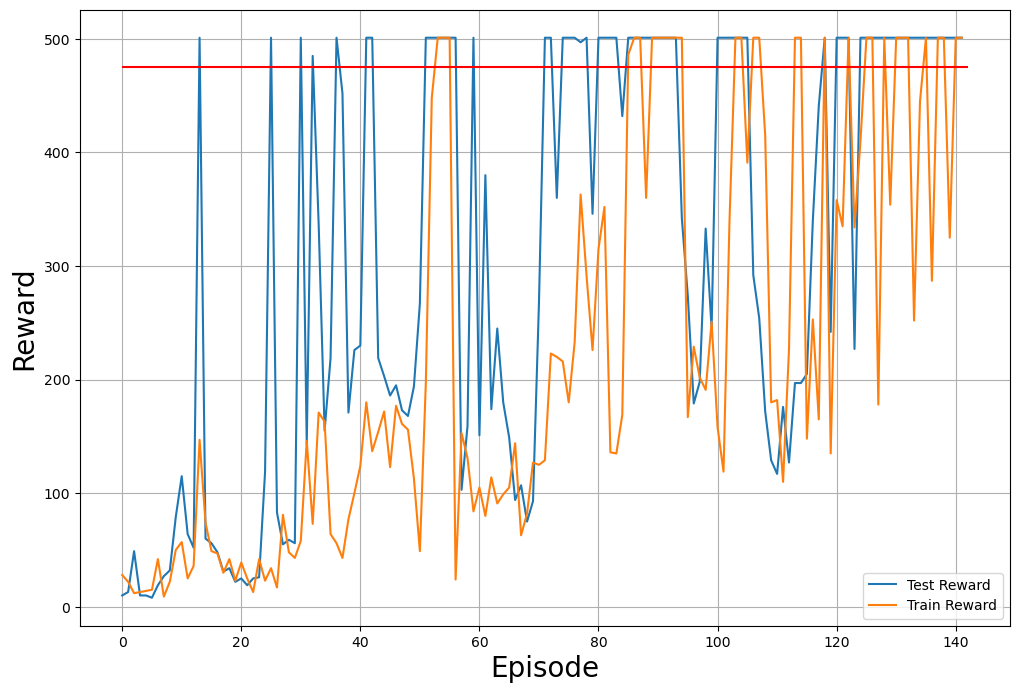

In [19]:
plt.figure(figsize=(12,8))
plt.plot(testRewards, label='Test Reward')
plt.plot(trainRewards, label='Train Reward')
plt.xlabel('Episode', fontsize=20)
plt.ylabel('Reward', fontsize=20)
plt.hlines(rewardThreshold, 0, len(testRewards), color='r')
plt.legend(loc='lower right')
plt.grid()

## Notes To Self

This is my first time utilizing PyTorch, so some the implementation of this is mainly a direct copy with some adjustments from [here](https://github.com/bentrevett/pytorch-rl/tree/master) to learn implementing algorithms on PyTorch. I do plan to utilize this method of learning to apply this to different scenarios to further my understanding.

KL Divergence for Machine Learning: https://dibyaghosh.com/blog/probability/kldivergence.html 
- Essentially: "KL divergence is used to calculate an expected upper bound and expected lower bound of what the next step's output values will be. This effectively gives you a frame of reference to determine how well your model is performing as it explores the different model weights. The model starts off with a high KL value since you know nothing about the feature space but as you go along the KL value mostly becomes smaller." - [Source](https://www.reddit.com/r/reinforcementlearning/comments/kcqbhv/hi_all_can_anyone_please_help_me_understand_how/)

Explanation of PPO Algorithm: https://spinningup.openai.com/en/latest/algorithms/ppo.html#id2
- Derivation of the simplified PPO Algorithm can be found here https://drive.google.com/file/d/1PDzn9RPvaXjJFZkGeapMHbHGiWWW20Ey/view

TODO:
- Take a look at PPO2 with a better Generalized Advantage Estimation
- Go over the math in the blog [here](https://dibyaghosh.com/blog/probability/kldivergence.html ) 
